# Шаг 7. Машинное обучение

### Импорт необходимых библиотек

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np

# функции из sklearn импортируются далее по файлу в начале каждого раздела

In [2]:
df = pd.read_csv('data/df_after_step05.csv', index_col=0)

## Что предсказываем

Мы предсказываем курс валютной пары USD/RUB, учитывая рыночную ситуацию в тот же день. 

Это интересно, так как курс доллара нестабилен в последнее время и кажется, что он не зависит от какого-то отдельного численного фактора в явном виде, однако может зависеть от рыночной картины в целом. 

Очевидно, что на курс доллара сильно влияет новостной фон, и мы постарались собрать такие данные, которые помогут его считать без объемной обработки текстовых данных из новостных ресурсов.

## Предварительная подготовка данных

Для того, чтобы обучать модели, нужно:

- Преобразовать нечисловые признаки: перевести все категориальные признаки в числовой формат
- Разделить выборки на обучающую (train) и тестовую (test)
- Отмасштабировать признаки

### Преобразование нечисловых признаков

In [3]:
# поскольку категориальная переменная бинарна, можно не увеличивать размерность и оставить всё в одной колонке
df_ml = pd.get_dummies(df, drop_first=True)

# так как название задваивается, вернем его к нормальному виду
df_ml.rename(columns={'workday_workday': 'workday'}, inplace=True)

df_ml.head()

usdrub    gold  cb_key_rate  fed_rate  imoex_open  imoex_close  \
09.10.2008  26.1629  767.98         11.0       1.4      637.93       700.37   
10.10.2008  26.0695  743.23         11.0       1.4        0.00       700.37   
13.10.2008  26.0695  743.23         11.0       1.4      700.37       666.37   
14.10.2008  26.1111  726.16         11.0       1.4      666.81       755.22   
15.10.2008  26.0871  712.49         11.0       1.4      755.22       689.71   

            ru_cpi      us_cpi  first_workday  second_workday  imoex_vol  \
09.10.2008  100.91  100.867301              0               0      62.44   
10.10.2008  100.91  100.867301              0               0     700.37   
13.10.2008  100.91  100.867301              1               0     -34.00   
14.10.2008  100.91  100.867301              0               1      88.41   
15.10.2008  100.91  100.867301              0               0     -65.51   

            ru_monetary  us_monetary  workday  
09.10.2008         0.08    -9.007613        1  
10.10.2008         0.08    -9.007613        1  
13.10.2008         0.08    -9.007613        1  
14.10.2008         0.08    -9.007613        1  
15.10.2008         0.08    -9.007613        1

### Разделение выборки на тестовую и обучающую

In [4]:
#import sklearn.model_selection
from sklearn.model_selection import train_test_split

In [5]:
y = df_ml['usdrub']
X = df_ml.drop(columns=['usdrub'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

In [6]:
# для графиков далее

X_train.index = pd.to_datetime(X_train.index, format='%d.%m.%Y')
X_train = X_train.sort_index()
y_train.index = pd.to_datetime(y_train.index, format='%d.%m.%Y')
y_train = y_train.sort_index()

X_test.index = pd.to_datetime(X_test.index, format='%d.%m.%Y')
X_test = X_test.sort_index()
y_test.index = pd.to_datetime(y_test.index, format='%d.%m.%Y')
y_test = y_test.sort_index()

dates_train = X_train.index
dates_test = X_test.index
#.strftime('%d.%m.%Y')

### Масштабирование признаков

Выберем, при помощи чего масштабировать данные:
- **StandardScaler**: 
    - Плюсы: учитывает и сохраняет специфику данных
    - Минусы: предполагает нормальное распределение. Как можно увидеть на графиках в [step04](https://github.com/evelinakolomoets/andan_project/blob/main/step04_plots.ipynb), наши данные не распределены по нормальному закону
    - **Вывод**: скорее не подходит
- **MinMaxScaler**:
    - Плюсы: интуитивно понятно
    - Минусы: может потеряться информация, связанная со спецификой данных
    - **Вывод**: скорее не подходит

- **RobustScaler**:
    - Плюсы: хорошо работает с асимметрией в данных (как видно на [графиках](https://github.com/evelinakolomoets/andan_project/blob/main/step04_plots.ipynb), она присутствует в нашем датасете)
    - Минусы: никак не учитываются среднее и медиана
    - **Вывод**: подходит лучше, чем первые два варианта


In [7]:
from sklearn.preprocessing import RobustScaler

In [8]:
scaler = RobustScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## Обучение моделей
Поскольку курс USD/RUB практически непрерывен, мы будем строить регрессионные модели.

Для того, чтобы выбрать лучшую модель, нужно подобрать её гиперпараметры и подобрать оптимальные метрики для оценки качества. Мы рассмотрим наиболее популярные метрики для задач регрессии:
- $MSE$ - сильно штрафует за большие ошибки. Чем меньше, тем лучше модель
- $MAE$ - менее чувствительна к выбросам, чем $MSE$. Чем меньше, тем лучше модель
- $R^2$ - показывает, какая доля дисперсии в таргете объясняется независимыми переменными. Чем больше, тем лучше модель

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# необходимо для реализации функции ниже
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
scoring = {'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error',
           'R2': 'r2'}

In [11]:
colors = sns.husl_palette(4)

def plot_true_vs_predict(y_train, y_train_pred, y_test, y_test_pred,model_name):
    ''' Рисует график истинных и предсказанных значений на обучающей выборке. 
    Нужен, чтобы определить, не переобучилась/недоучилась ли модель'''
    plt.figure(figsize=(10, 4), dpi=300)
    
    plt.subplot(1, 2, 1)
    plt.title(f'График истинных и предсказанных \nпо модели "{model_name}" \nзначений таргета на обучающей выборке', fontsize=10)
    sns.scatterplot(x=dates_train, y=y_train, color=colors[0], linewidth=0.25, label='True')
    sns.lineplot(x=dates_train, y=y_train_pred, color=colors[3], label='Predict')
    plt.xlabel('Объекты')
    plt.ylabel('Target')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title(f'График истинных и предсказанных \nпо модели "{model_name}" \nзначений таргета на тестовой выборке', fontsize=10)
    sns.scatterplot(x=dates_test, y=y_test, color='yellowgreen', linewidth=0.25, label='True')
    sns.lineplot(x=dates_test, y=y_test_pred, color=colors[2], label='Predict')
    plt.xlabel('Объекты')
    plt.ylabel('Target')
    plt.legend()
    
    plt.tight_layout();
    
def get_quality(y_train, y_train_pred, y_test, y_test_pred, model_name):
    ''' Считает MSE, MAE, R^2 на обучающей и тестовой выборках'''
    metrics = {
        'Метрики на обучающей выборке': {
            'MSE': mean_squared_error(y_train, y_train_pred),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'R^2': r2_score(y_train, y_train_pred)
        },
        'Метрики на тестовой выборке': {
            'MSE': mean_squared_error(y_test, y_test_pred),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'R^2': r2_score(y_test, y_test_pred)
        }
    }
    plot_true_vs_predict(y_train, y_train_pred, y_test, y_test_pred, model_name)
    return metrics

In [12]:
model_results = {}

# словарь вида "модель": метрики

In [13]:
def depth(d):
    '''Считает глубину словаря. 
    Взята отсюда: https://stackoverflow.com/questions/23499017/know-the-depth-of-a-dictionary'''
    if isinstance(d, dict):
        return 1 + (max(map(depth, d.values())) if d else 0)
    return 0

In [14]:
def dict_printer(dictionary, keys=[]):
    '''Функция, выводящая красиво словарь'''
    
    dictionary_res = dictionary
    if keys:
        for key_index in keys:
            dictionary_res = dictionary_res[key_index]
        
            
    depth_dict = depth(dictionary_res)
    
    if depth_dict == 1:
        for i in dictionary_res:
            print(f'{len(keys)*2*" "}• {i}: {dictionary_res[i]}')
        
    else:
        if not keys:
            for i in dictionary_res:
                print(f'\033[1m{i}\033[0m')
                dict_printer(dictionary, keys=[i])
                print(' ')
        else:
            for j in dictionary_res:
                print(f'{len(keys)*2*" "}{j}')
                dict_printer(dictionary, keys=list(dict.fromkeys(keys+[j])))

### kNN Regressor

Модель k ближайших соседей: предсказываемое значение - это среднее между k ближайшими соседями, то есть между k наиболее похожими объектами, ответ для которых модель знает.

__Возможные проблемы и недостатки__:
- Проклятие размерности: нам неактуально, т.к. небольшая размерность
- Равный вес разных признаков, хотя какой-то из них может быть важнее (например, IMOEX может быть связан с курсом более сильно, чем инфляция)

In [15]:
from sklearn.neighbors import KNeighborsRegressor

In [16]:
knn = KNeighborsRegressor()

gs = GridSearchCV(knn,
                  param_grid={
                      'n_neighbors': np.arange(5, 50, 5),
                      'p': np.arange(1, 3),
                      'metric': ['minkowski', 'euclidean', 'cosine', 'cityblock']
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_metric_knn = gs.best_params_['metric']
best_n = gs.best_params_['n_neighbors']
best_p = gs.best_params_['p']

dict_printer(gs.best_params_)

• metric: cosine
• n_neighbors: 5
• p: 1


Метрики на обучающей выборке
  • MSE: 3.3865665774220832
  • MAE: 1.1624782569444445
  • R^2: 0.9892419485722819
 
Метрики на тестовой выборке
  • MSE: 5.144298928357778
  • MAE: 1.533396722222222
  • R^2: 0.983941522950766
 


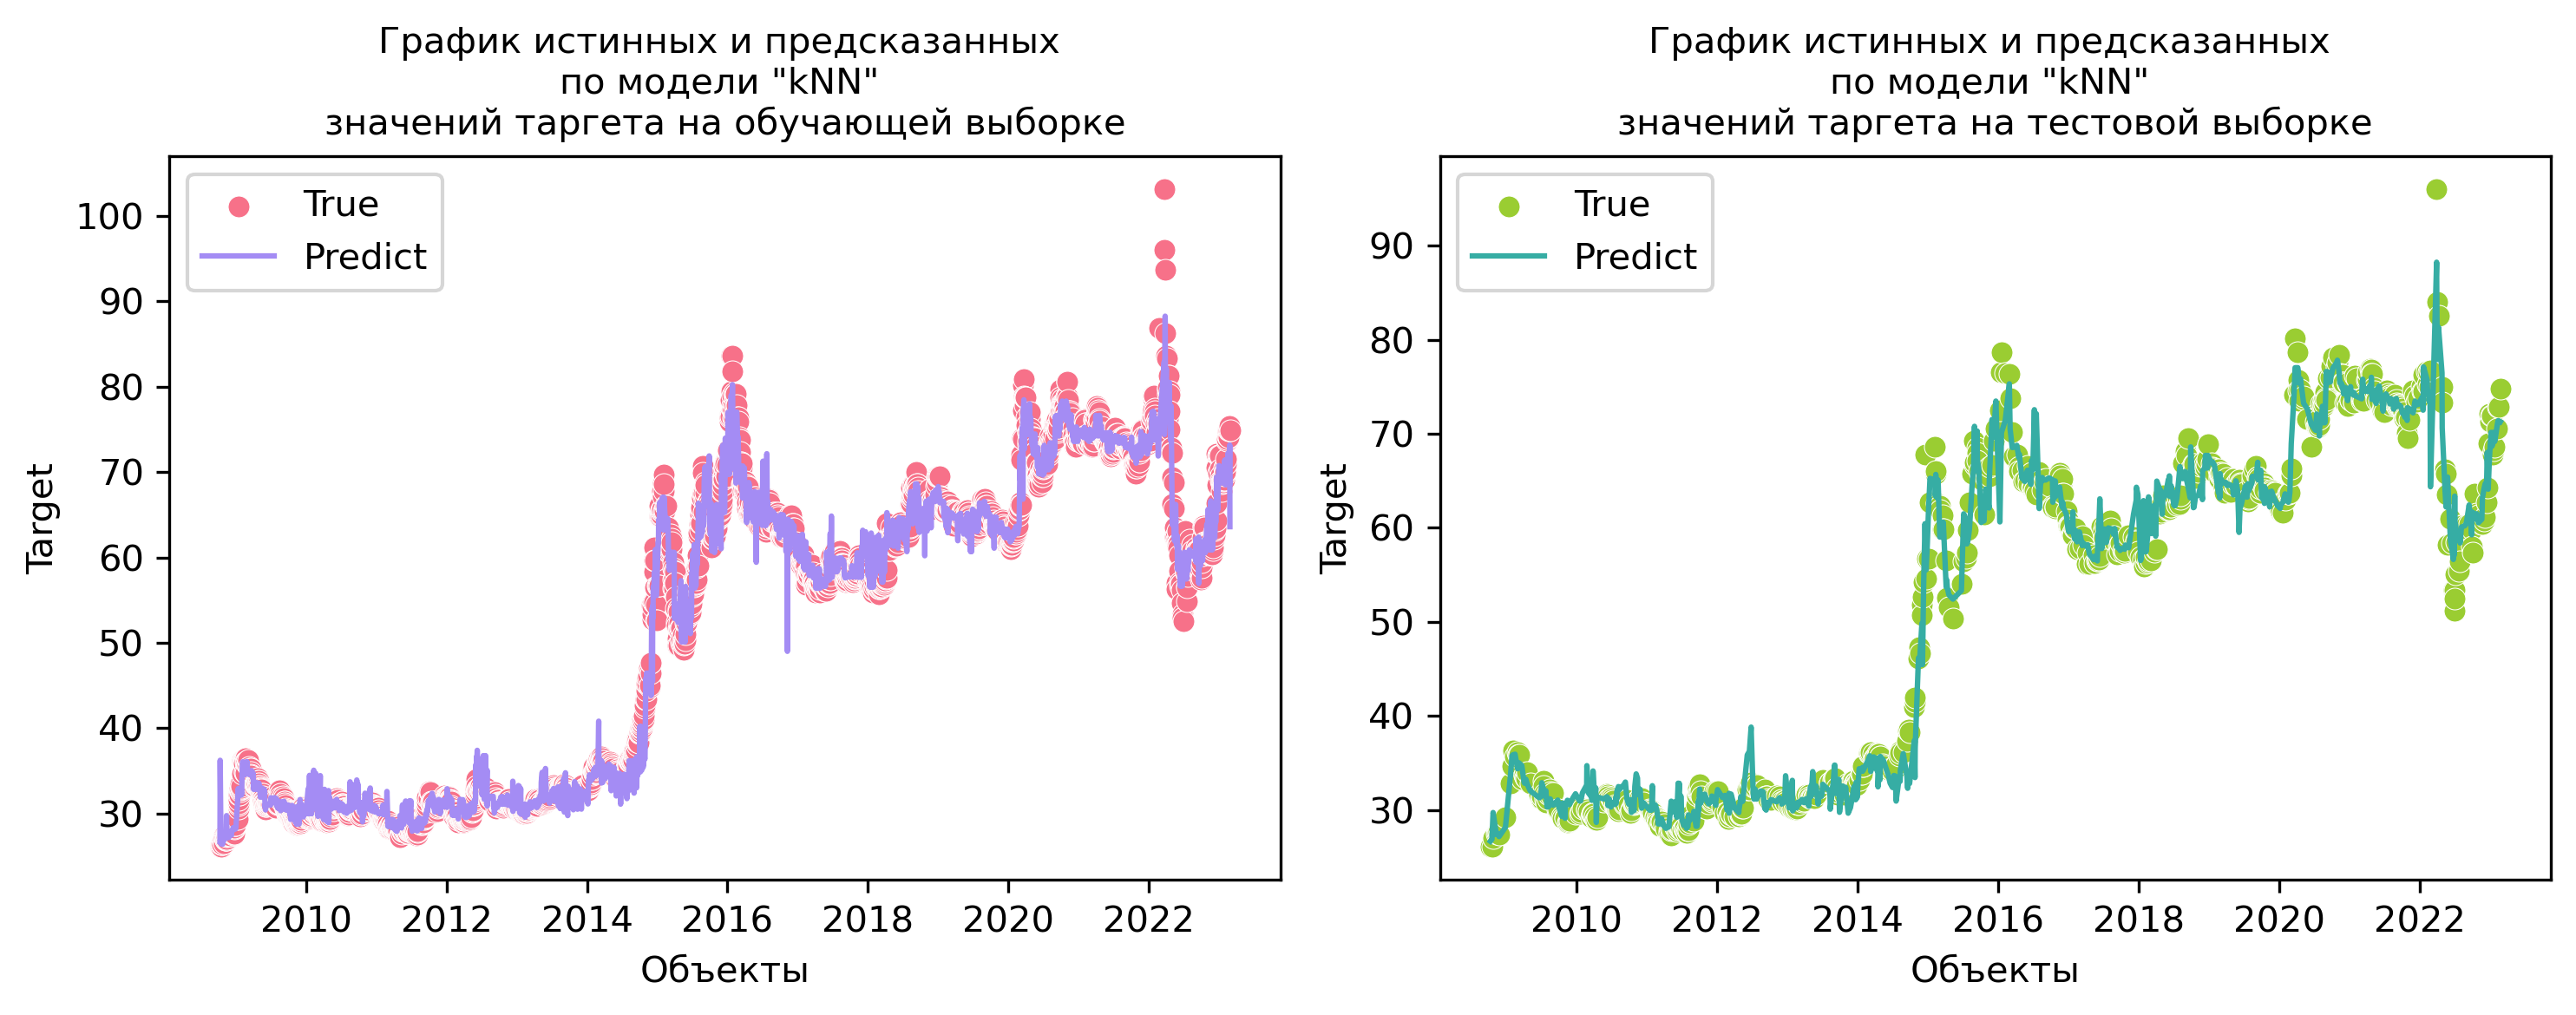

In [17]:
model_name = 'kNN'

best_knn = KNeighborsRegressor(metric=best_metric_knn,
                               n_neighbors=best_n,
                               p=best_p)

best_knn.fit(X_train_norm, y_train)
knn_metrics = get_quality(y_train, best_knn.predict(X_train_norm), y_test,
            best_knn.predict(X_test_norm), model_name)

model_results[model_name] = knn_metrics
dict_printer(knn_metrics)

> Модель качественно предсказывает значения курса, однако есть подозрение, что из-за равных весов она иногда "промазывает" и неправильно определяет ближайшие объекты: это видно по, например, скачкам в районе 2017 года на обучающей выборке и в районе  2012 года на тестовой выборке.

### Линейная регрессия
__Возможные проблемы и недостатки__:
- Не видит нелинейную зависимость между переменными
- Очень склонна к переобучению

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
lr = LinearRegression()

gs = GridSearchCV(lr,
                  param_grid={
                      'fit_intercept': [True, False],
                      'positive': [True, False],
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_norm, y_train)

best_fit_intercept = gs.best_params_['fit_intercept']
best_positive = gs.best_params_['positive']

dict_printer(gs.best_params_)

• fit_intercept: True
• positive: True


Метрики на обучающей выборке
  • MSE: 38.04985696375275
  • MAE: 4.917955856683354
  • R^2: 0.8791276330539552
 
Метрики на тестовой выборке
  • MSE: 36.713180787540836
  • MAE: 4.853911160904676
  • R^2: 0.8853958956717726
 


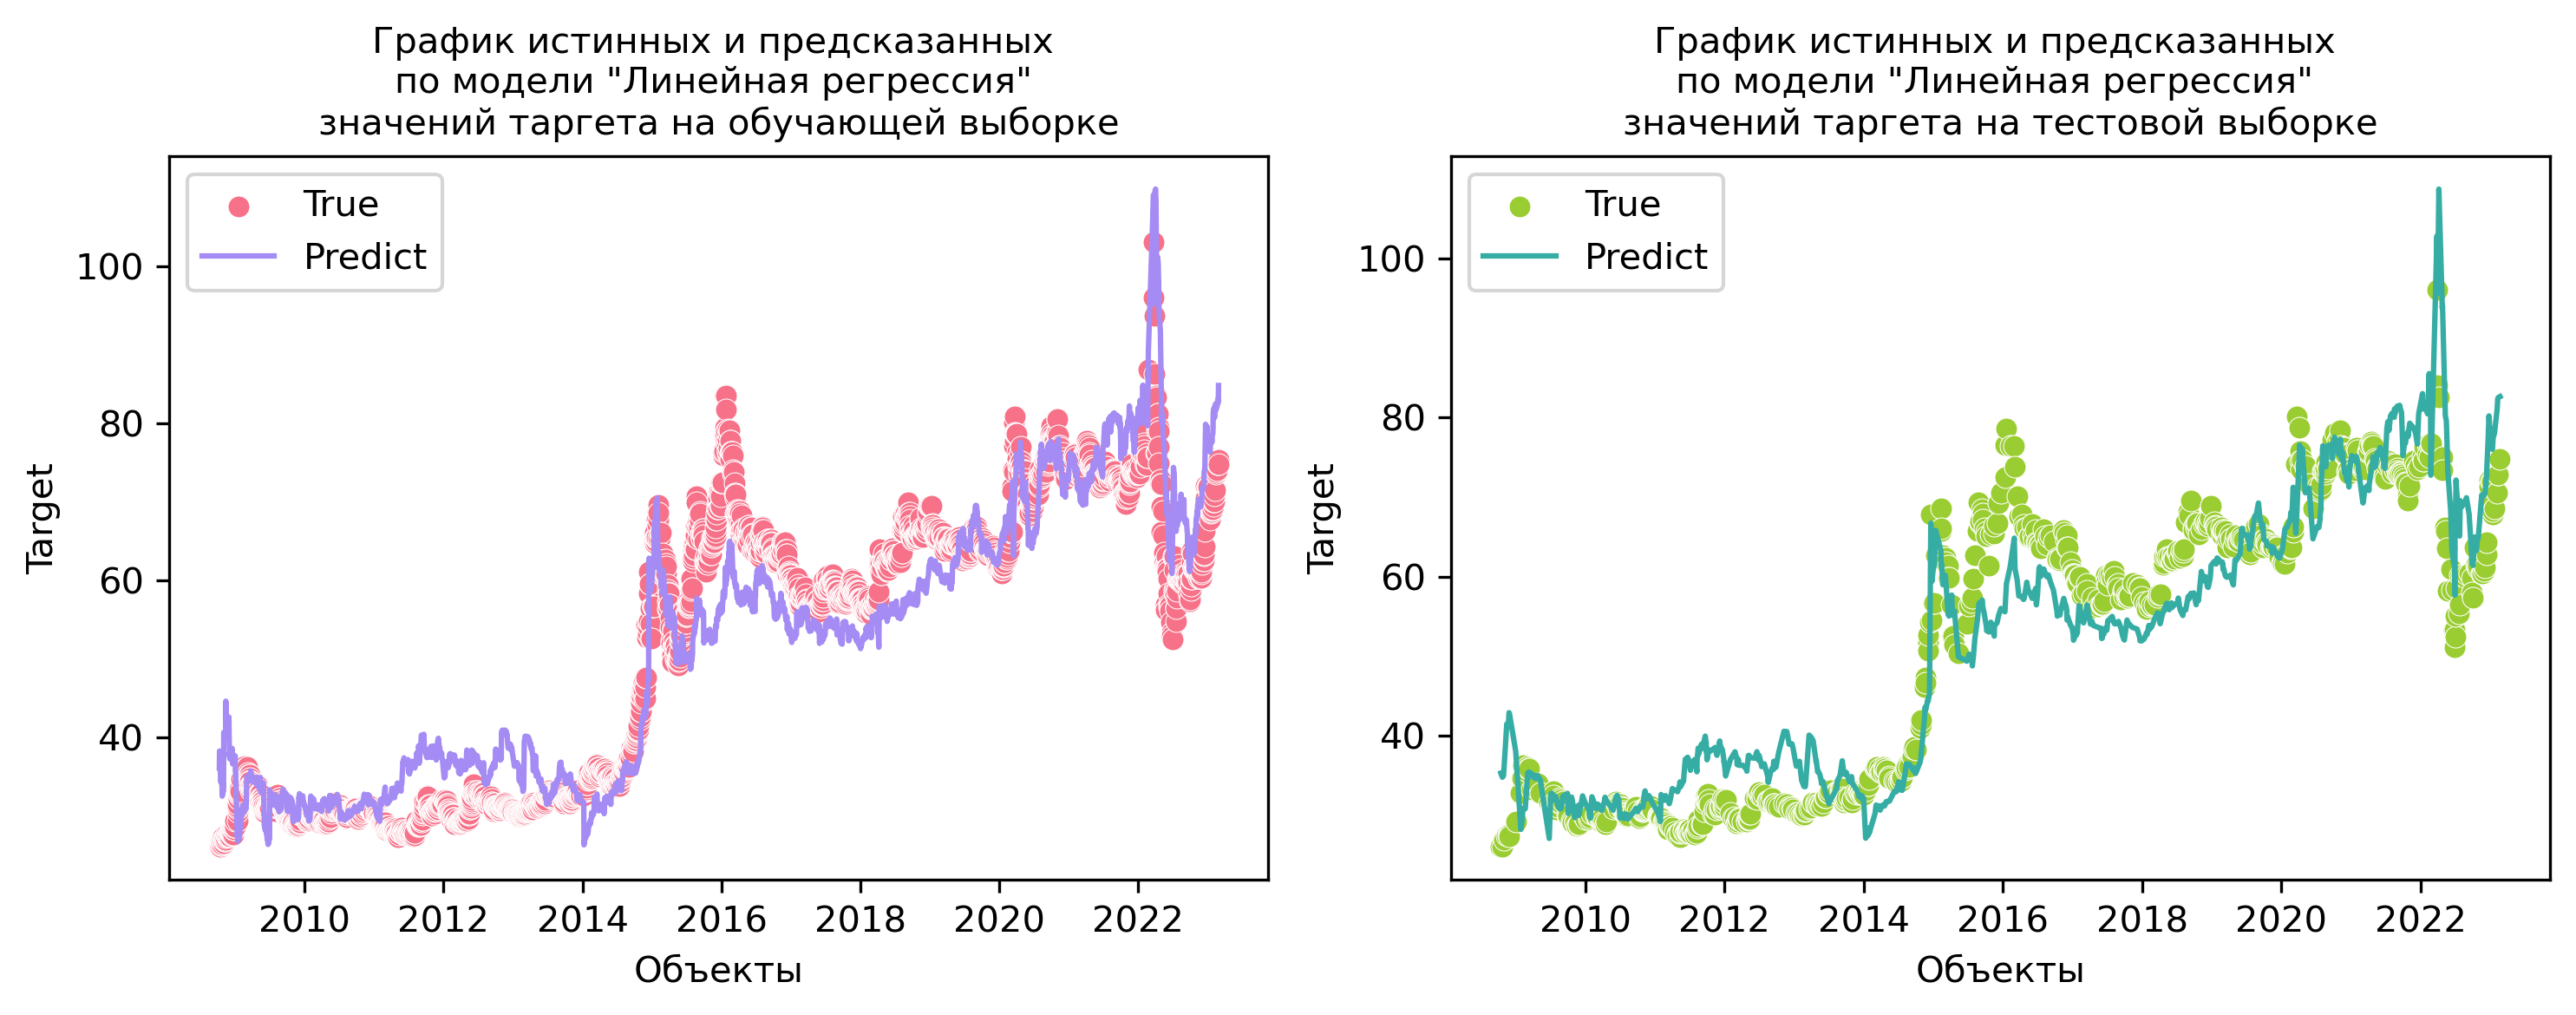

In [20]:
model_name = 'Линейная регрессия'

best_lr = LinearRegression(fit_intercept=best_fit_intercept,
                               positive=best_positive)

best_lr.fit(X_train_norm, y_train)
lr_metrics = get_quality(y_train, best_lr.predict(X_train_norm), y_test,
            best_lr.predict(X_test_norm), model_name)

model_results[model_name] = lr_metrics
dict_printer(lr_metrics)

> Модель ощутимо проигрывает более простой kNN: она достаточно хорошо предсказывает тренд и двигается в том же направлении, что и реальный курс доллара, однако она очень неточная: даже без точных значений метрик видно, как она не попадает в реальные значения курса на интервале 2010-2014 гг и 2015-2020 гг.

### LASSO-регрессия

LASSO (Least Absolute Shrinkage and Selection Operator) - улучшенная версия линейной регрессии с $L_1$-регуляризатором, т.е. она дополнительно штрафует большие веса их модулем с некоторым весом (и тем самым борется с переобучением).

In [21]:
from sklearn.linear_model import Lasso

In [22]:
lasso = Lasso(random_state=7)

gs = GridSearchCV(lasso,
                  param_grid={
                      'alpha': np.concatenate((0.1**np.arange(1, 6), 10**np.arange(6))),
                      'tol': 0.1**np.arange(10),
                      'positive': [True, False],
                      'fit_intercept': [True, False],
                      'selection': ['cyclic', 'random']
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_alpha_lasso = gs.best_params_['alpha']
best_fit_intercept_lasso = gs.best_params_['fit_intercept']
best_tol_lasso = gs.best_params_['tol']
best_positive_lasso = gs.best_params_['positive']
best_selection_lasso = gs.best_params_['selection']

dict_printer(gs.best_params_)

• alpha: 0.010000000000000002
• fit_intercept: True
• positive: False
• selection: random
• tol: 0.1


Метрики на обучающей выборке
  • MSE: 52.270998626489344
  • MAE: 5.818943061210426
  • R^2: 0.8339515616934903
 
Метрики на тестовой выборке
  • MSE: 50.39126174234722
  • MAE: 5.790578931309382
  • R^2: 0.8426983090522404
 


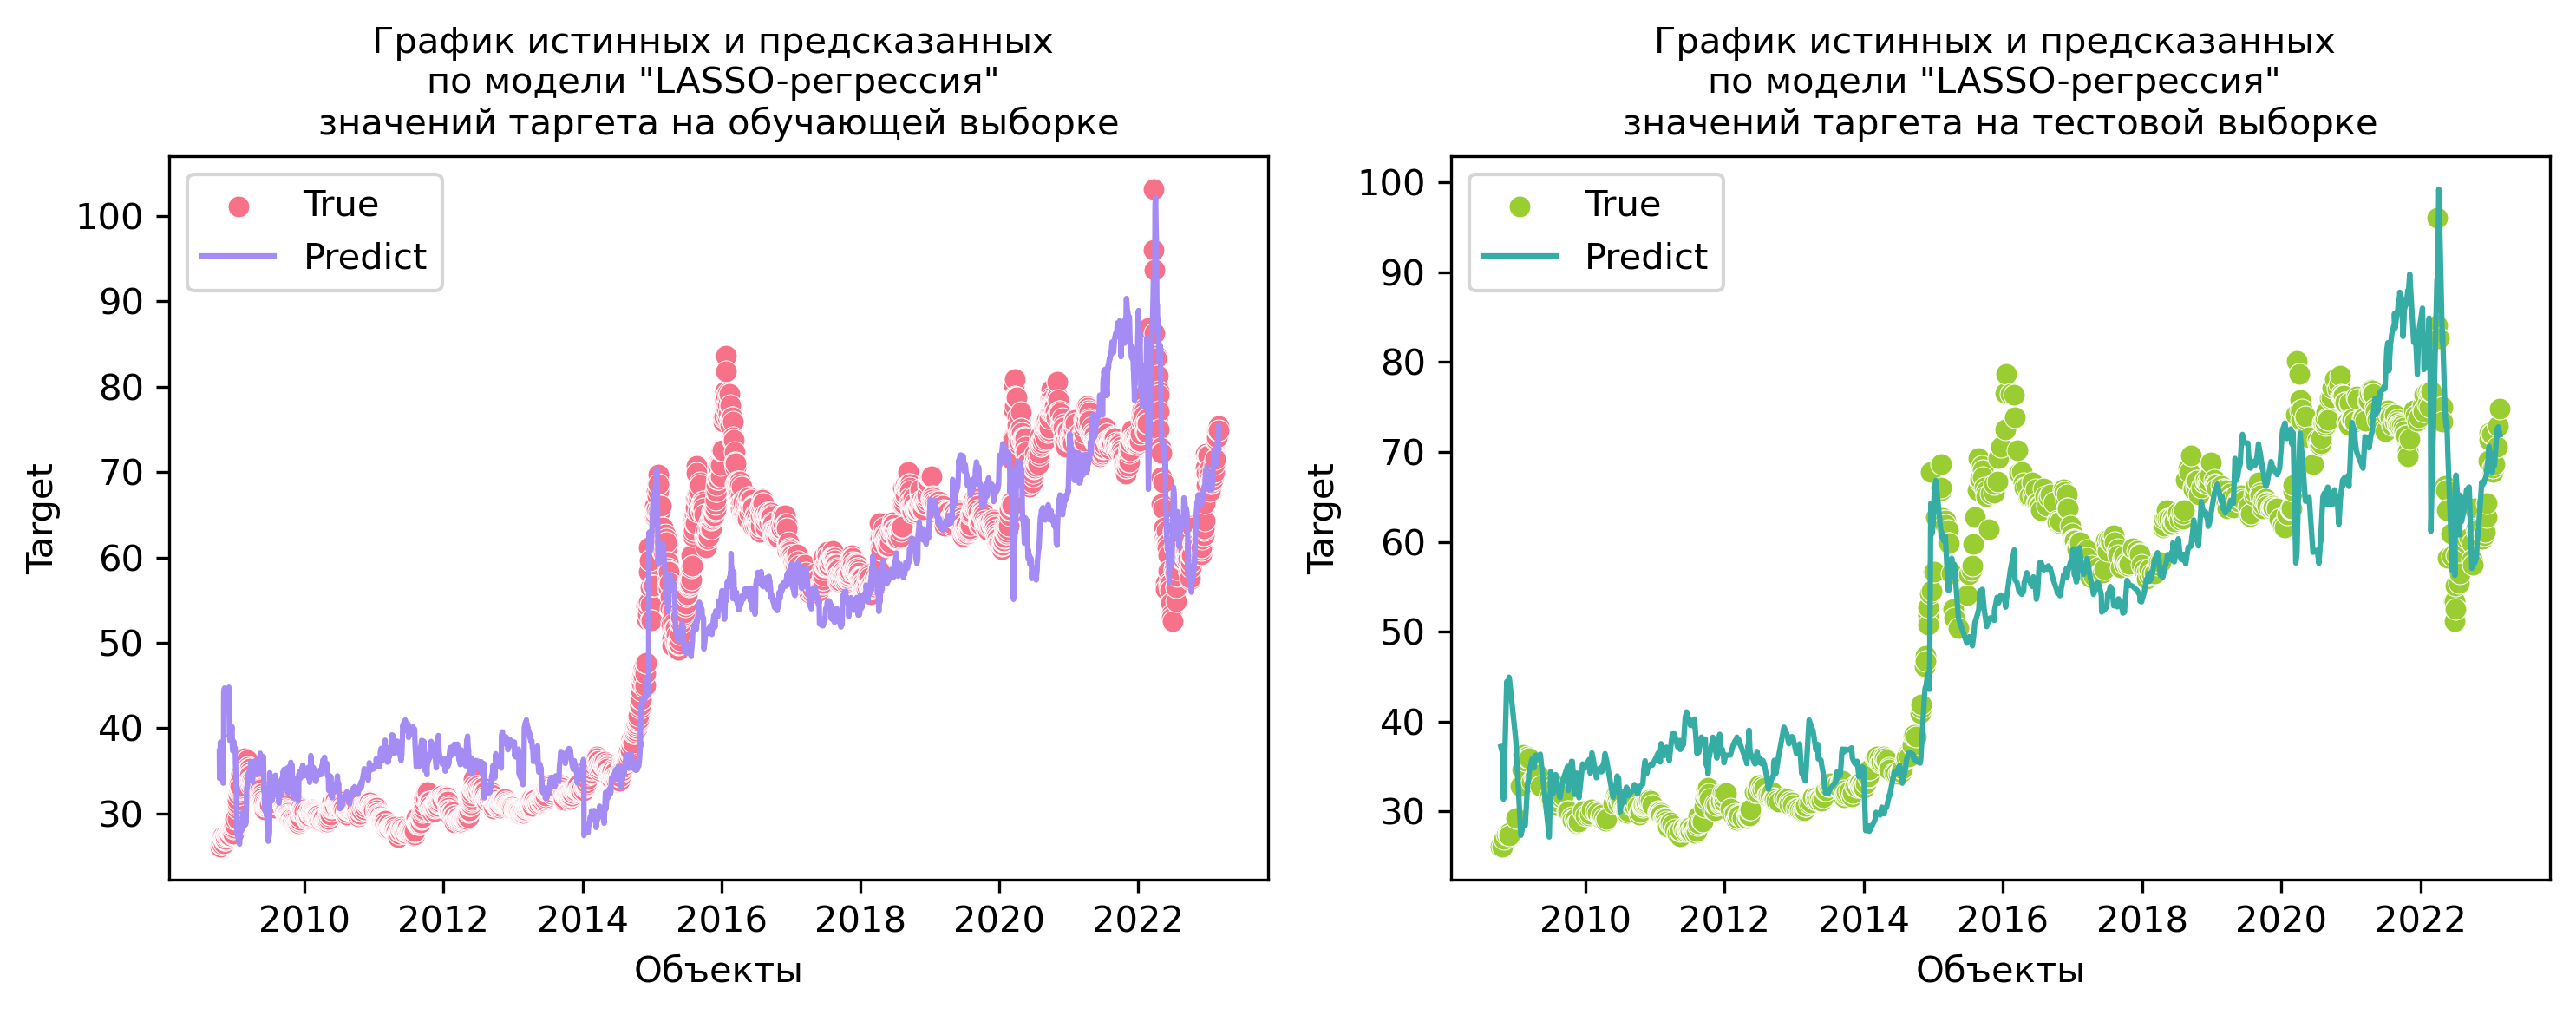

In [23]:
model_name = 'LASSO-регрессия'

best_lasso = Lasso(alpha=best_alpha_lasso,
                   fit_intercept=best_fit_intercept_lasso,
                   tol=best_tol_lasso,
                   positive=best_positive_lasso,
                   selection=best_selection_lasso, random_state=7)

best_lasso.fit(X_train_norm, y_train)
lasso_metrics = get_quality(y_train, best_lasso.predict(X_train_norm), y_test,
                            best_lasso.predict(X_test_norm), model_name)

model_results[model_name] = lasso_metrics
dict_printer(lasso_metrics)

> Модель хуже обычной линейной регрессии: она не распознает некоторые существенные приросты курса - как, например в 2016.

In [41]:
# нужно для гипотез на 6 шаге

coeffs = best_lasso.coef_

with open('step06_lasso_coeffs.txt', 'w') as file:
    for n, i in enumerate(coeffs):
        file.write(str(i))
        if n+1 != coeffs.shape[0]:
            file.write('\n')

### Ridge-регрессия
Ridge - улучшенная версия линейной регрессии с  $L_2$-регуляризатором, т.е. она дополнительно штрафует большие веса корнем из суммых их квадратов с некоторым весом (и тем самым борется с переобучением).

In [24]:
from sklearn.linear_model import Ridge

In [25]:
ridge = Ridge(random_state=7)

gs = GridSearchCV(ridge,
                  param_grid={
                      'alpha': np.concatenate((0.1**np.arange(1, 6), 10**np.arange(6))),
                      'tol': 0.1**np.arange(10),
                      'positive': [True, False],
                      'fit_intercept': [True, False],
                      'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_alpha_ridge = gs.best_params_['alpha']
best_fit_intercept_ridge = gs.best_params_['fit_intercept']
best_tol_ridge = gs.best_params_['tol']
best_positive_ridge = gs.best_params_['positive']
best_solver_ridge = gs.best_params_['solver']

dict_printer(gs.best_params_)

• alpha: 10.0
• fit_intercept: True
• positive: False
• solver: sag
• tol: 0.1


Метрики на обучающей выборке
  • MSE: 39.21747445252734
  • MAE: 5.091057269855979
  • R^2: 0.8754184814087802
 
Метрики на тестовой выборке
  • MSE: 37.4451030542552
  • MAE: 5.010267252453557
  • R^2: 0.8831111223556138
 


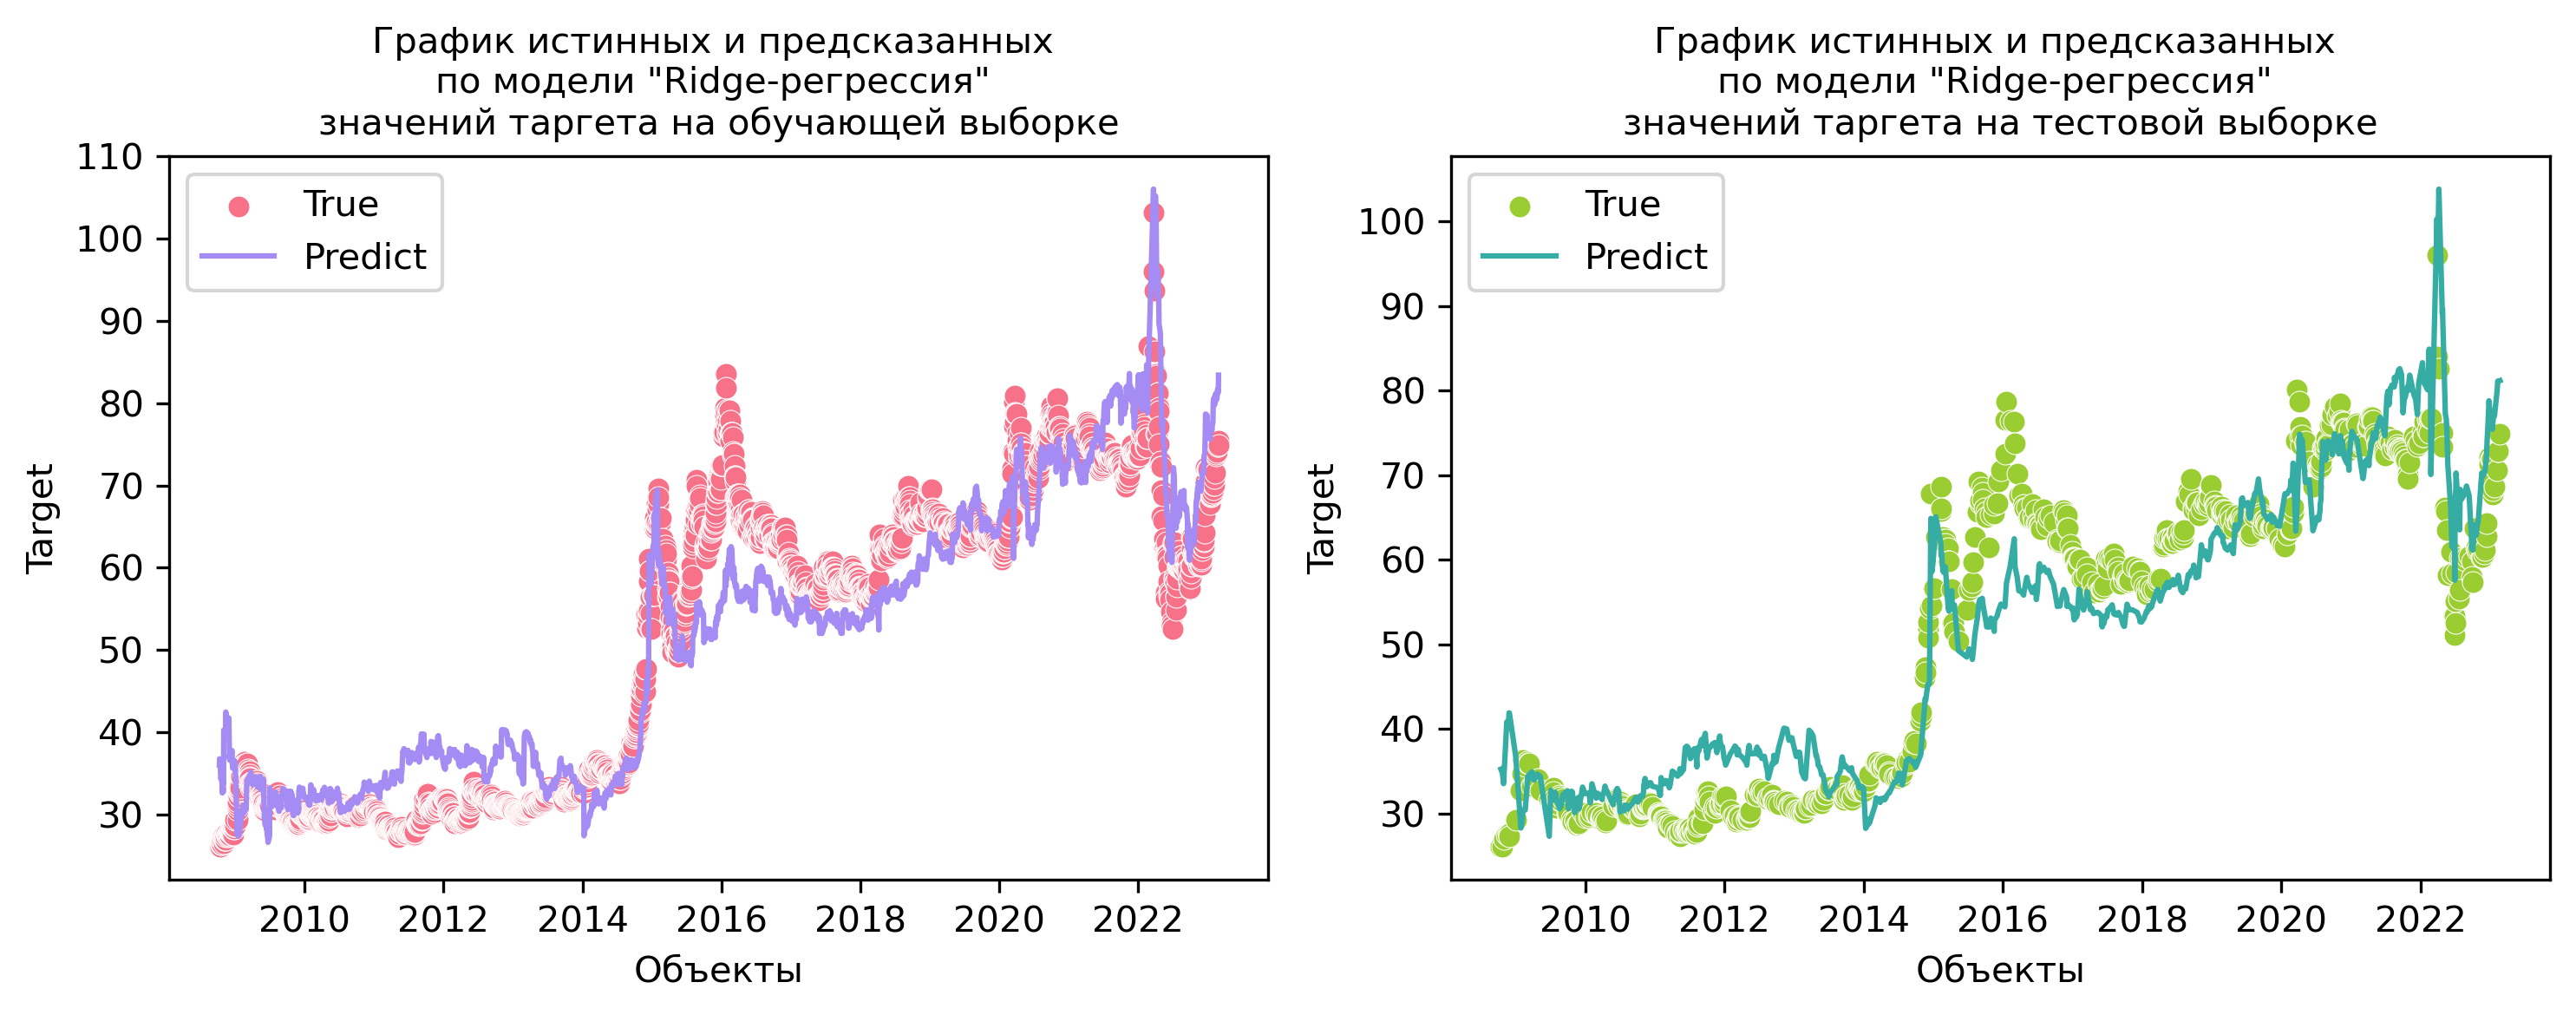

In [26]:
model_name = 'Ridge-регрессия'

best_ridge = Ridge(alpha=best_alpha_ridge,
                   fit_intercept=best_fit_intercept_ridge,
                   tol=best_tol_ridge,
                   positive=best_positive_ridge,
                   solver=best_solver_ridge, random_state=7)

best_ridge.fit(X_train_norm, y_train)
ridge_metrics = get_quality(y_train, best_ridge.predict(X_train_norm), y_test,
                            best_ridge.predict(X_test_norm), model_name)

model_results[model_name] = ridge_metrics
dict_printer(ridge_metrics)

> Модель выглядит практически так же, как и обычная линейная регрессия, как по метрикам, так и по графику

### Elastic-Net

Elastic-Net - это улучшенная версия линейной регрессии с обоими регуляризаторами: и $L_1$, и $L_2$.

In [27]:
from sklearn.linear_model import ElasticNet

In [28]:
enet = ElasticNet(random_state=7)

gs = GridSearchCV(enet,
                  param_grid={
                      'alpha': np.concatenate((0.1**np.arange(1, 6), 10**np.arange(6))),
                      'l1_ratio': np.arange(0, 1.05, 0.05),
                      'tol': 0.1**np.arange(10),
                      'positive': [True, False],
                      'fit_intercept': [True, False],
                      'selection': ['cyclic', 'random']
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_alpha_enet = gs.best_params_['alpha']
best_l1ratio_enet = gs.best_params_['l1_ratio']
best_tol_enet = gs.best_params_['tol']
best_positive_enet = gs.best_params_['positive']
best_fit_intercept_enet = gs.best_params_['fit_intercept']
best_selection_enet = gs.best_params_['selection']

dict_printer(gs.best_params_)

• alpha: 0.010000000000000002
• fit_intercept: True
• l1_ratio: 0.0
• positive: True
• selection: random
• tol: 0.1


Метрики на обучающей выборке
  • MSE: 52.085152850284
  • MAE: 5.81692206529072
  • R^2: 0.8345419349734283
 
Метрики на тестовой выборке
  • MSE: 50.16236028317082
  • MAE: 5.781494835979927
  • R^2: 0.8434128493384702
 


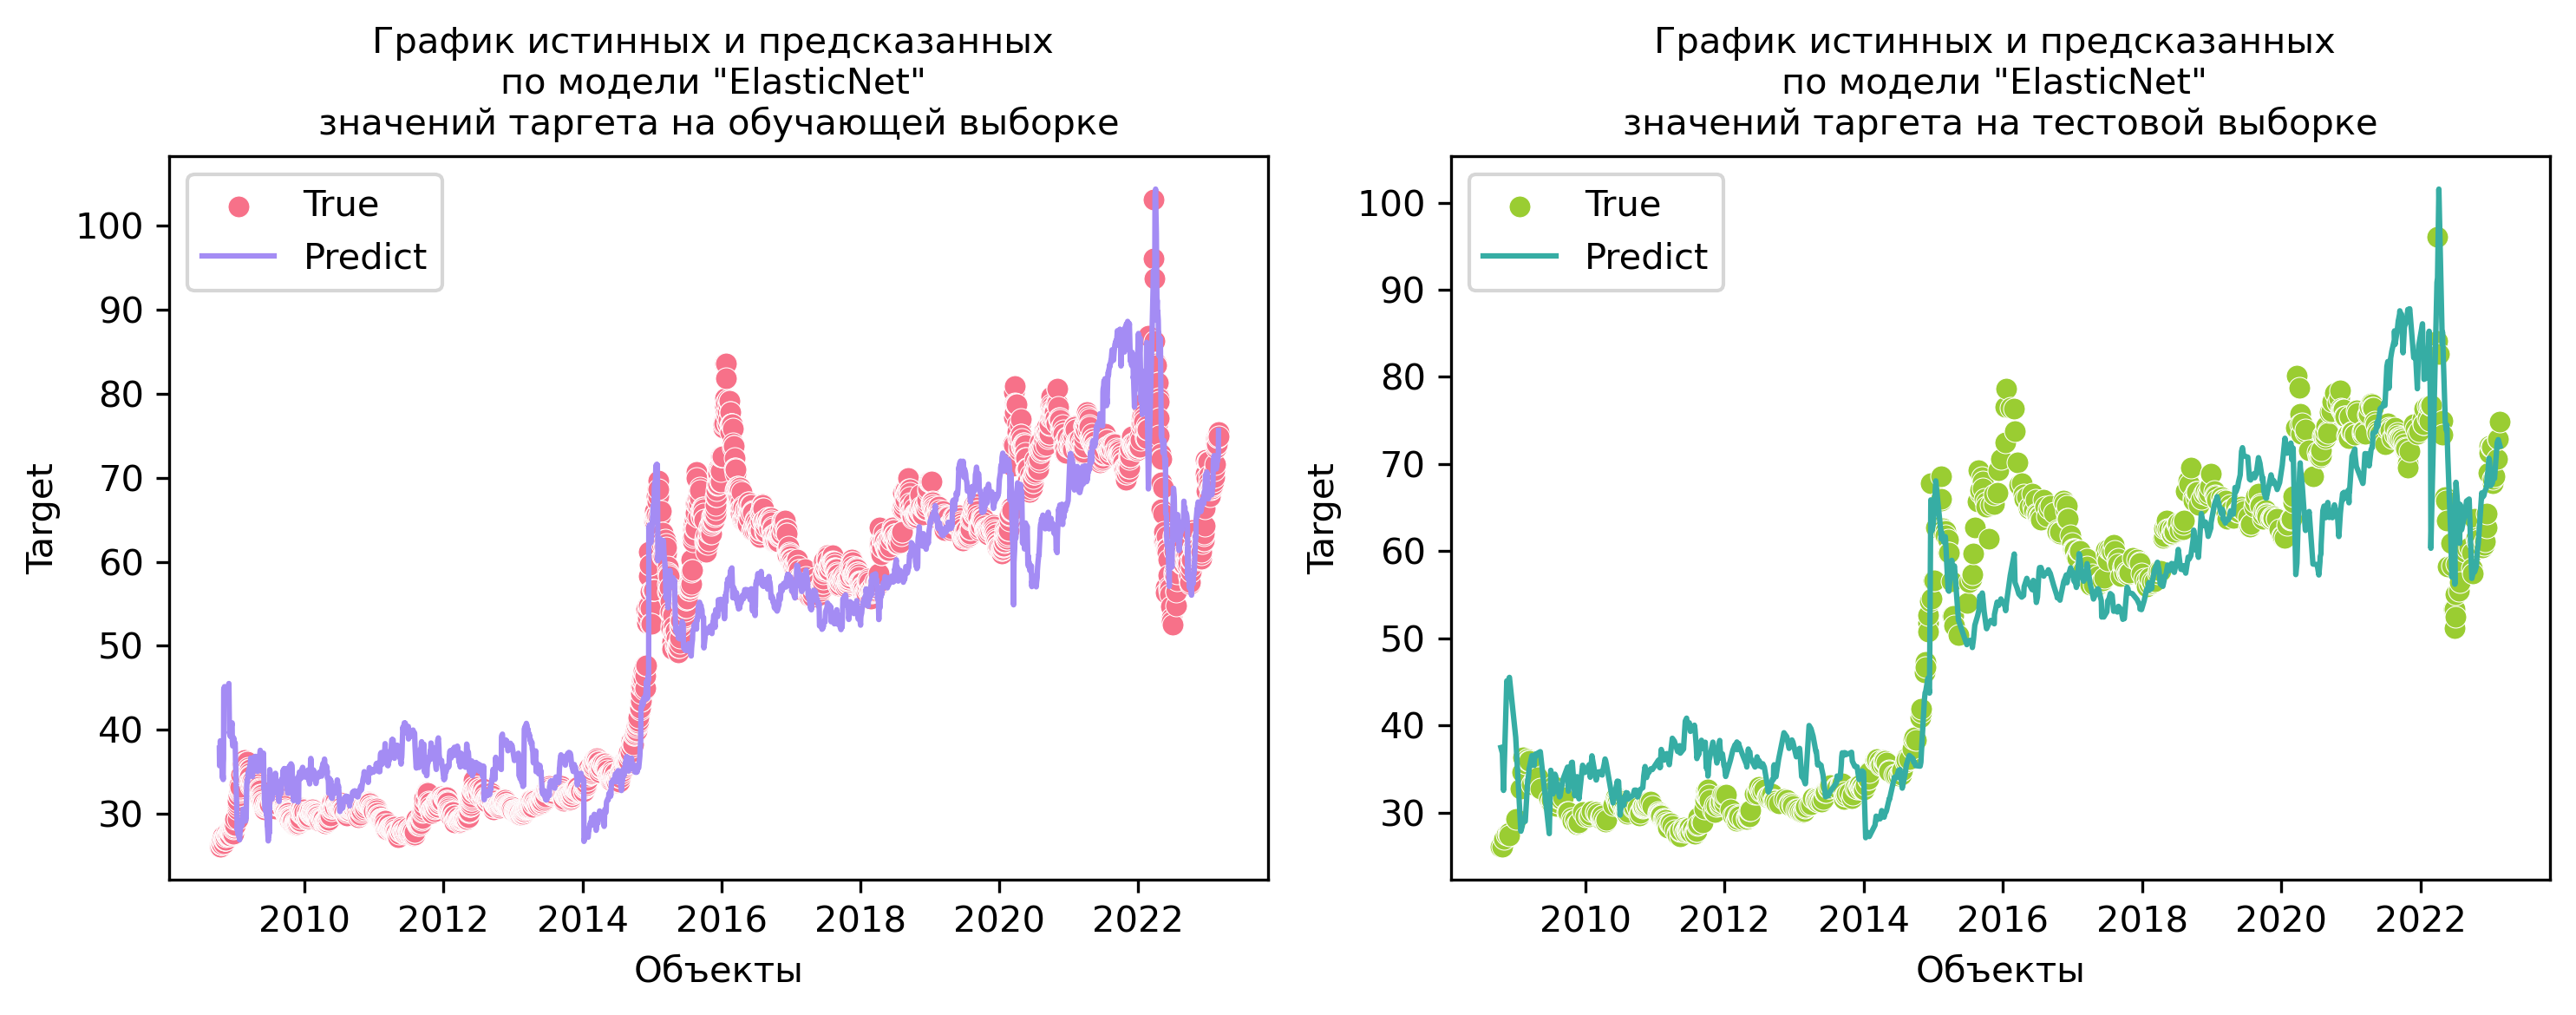

In [29]:
model_name = 'ElasticNet'

best_enet = ElasticNet(alpha=best_alpha_enet,
                       l1_ratio=best_l1ratio_enet,
                   fit_intercept=best_fit_intercept_enet,
                   tol=best_tol_enet,
                   positive=best_positive_enet,
                   selection=best_selection_enet, random_state=7)

best_enet.fit(X_train_norm, y_train)
enet_metrics = get_quality(y_train, best_enet.predict(X_train_norm), y_test,
                            best_enet.predict(X_test_norm), model_name)

model_results[model_name] = enet_metrics
dict_printer(enet_metrics)

> Стало ещё хуже: новая модель начала "промазывать" ещё и на интервале 2020-2022 гг, где предыдущие модели шли достаточно неплохо

### Решающее дерево Regressor
Регрессия при помощи решающего дерева - рекурсивный выбор предикатов для группировки и распределение объектов по "листам" по некоторым признакам, прогноз такой модели - среднее значение таргета по объектам обучающей выборки, которые попали в этот "лист".

In [30]:
from sklearn.tree import DecisionTreeRegressor

In [31]:
dt = DecisionTreeRegressor(random_state=7)

gs = GridSearchCV(dt,
                  param_grid={
                      'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                      'splitter': ['best', 'random'],
                      'max_features': [None, 'sqrt', 'log2'],
                      'ccp_alpha': np.arange(0,3,0.1)
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_criterion_dt = gs.best_params_['criterion']
best_splitter_dt = gs.best_params_['splitter']
best_maxfeatures_dt = gs.best_params_['max_features']
best_ccp_dt = gs.best_params_['ccp_alpha']

dict_printer(gs.best_params_)

• ccp_alpha: 0.30000000000000004
• criterion: absolute_error
• max_features: None
• splitter: best


Метрики на обучающей выборке
  • MSE: 13.141815465342011
  • MAE: 2.3959675
  • R^2: 0.9582526067633512
 
Метрики на тестовой выборке
  • MSE: 12.171027995152778
  • MAE: 2.339236666666667
  • R^2: 0.9620068397175864
 


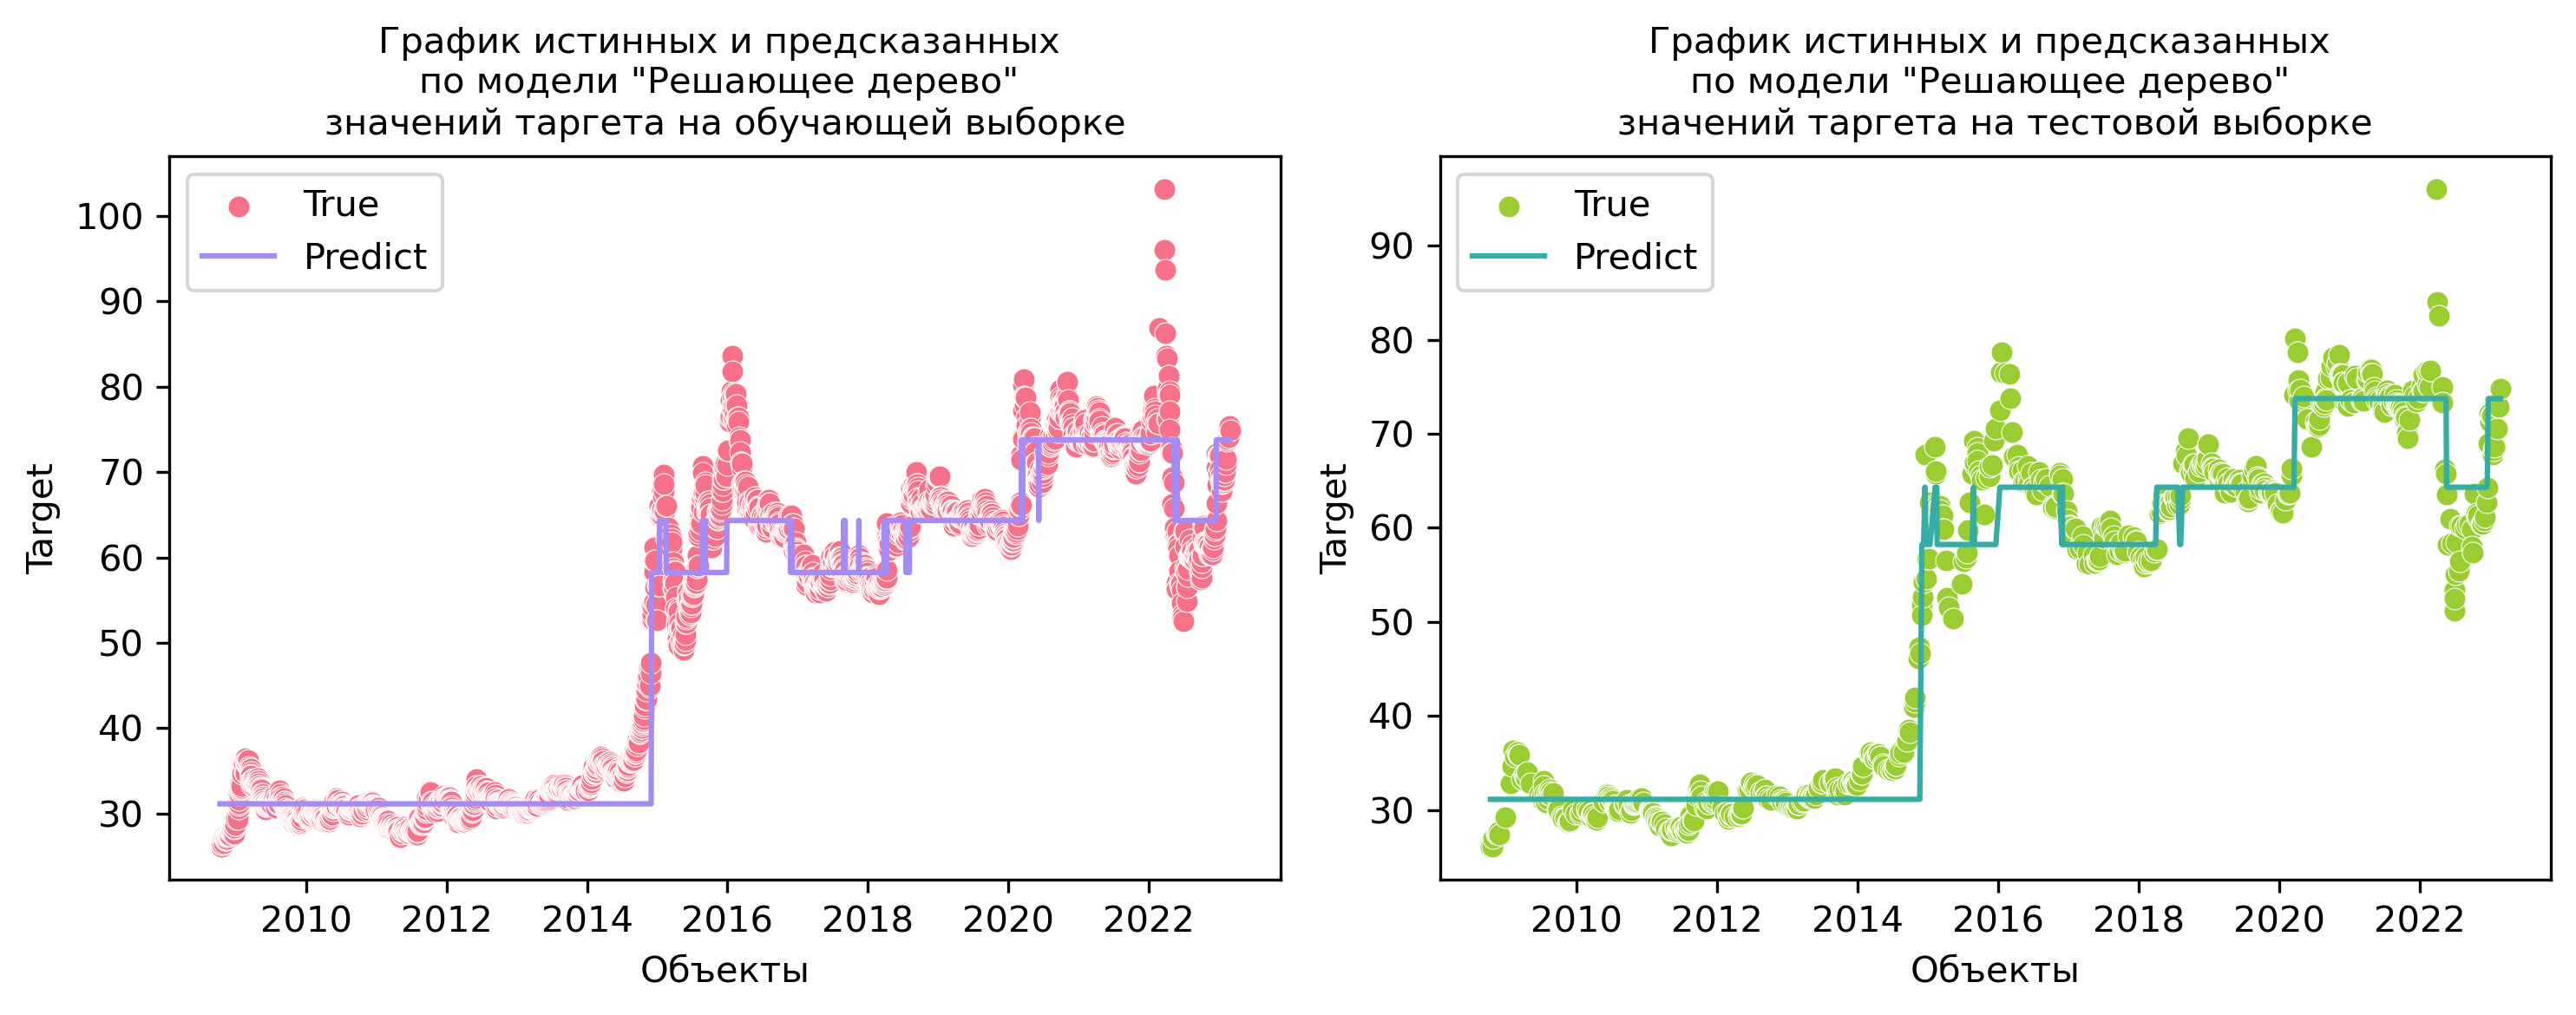

In [32]:
model_name = 'Решающее дерево'

best_dt = DecisionTreeRegressor(criterion=best_criterion_dt, splitter=best_splitter_dt, 
                                max_features=best_maxfeatures_dt, 
                                ccp_alpha=best_ccp_dt, random_state=7)

best_dt.fit(X_train_norm, y_train)
dt_metrics = get_quality(y_train, best_dt.predict(X_train_norm), y_test,
                            best_dt.predict(X_test_norm), model_name)

model_results[model_name] = dt_metrics
dict_printer(dt_metrics)

> Несмотря на то, что кажется, что от модели, просто строящей прямые линии, не стоит ожидать блестящих результатов, но она сработала сравнительно хорошо: метрики лучше, чем у линейной регрессии, и в целом предсказания реже идут не в том направлении, котором нужно

### Композиции моделей

#### Случайный лес Regressor

Случайный лес для задачи регрессии комбинирует некоторое количество решающих деревьев и считает предсказанием средний ответ деревьев.

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
rf = RandomForestRegressor(random_state=7)

gs = GridSearchCV(rf,
                  param_grid={
                      'n_estimators': np.arange(0, 151, 10), 
                      'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
                      'bootstrap': [True, False],
                      'max_features': [None, 'sqrt', 'log2']
                  },
                  scoring=scoring,
                  refit='MAE',
                  cv=5)

gs.fit(X_train_norm, y_train)

best_n_rf = gs.best_params_['n_estimators']
best_criterion_rf = gs.best_params_['criterion']
best_bootstrap_rf = gs.best_params_['bootstrap']
best_maxfeatures_rf = gs.best_params_['max_features']

dict_printer(gs.best_params_)

• bootstrap: True
• criterion: absolute_error
• max_features: None
• n_estimators: 60


Метрики на обучающей выборке
  • MSE: 0.10715852746375322
  • MAE: 0.1713465700231483
  • R^2: 0.999659591234066
 
Метрики на тестовой выборке
  • MSE: 0.4715078667874878
  • MAE: 0.41906095370370355
  • R^2: 0.9985281379712206
 


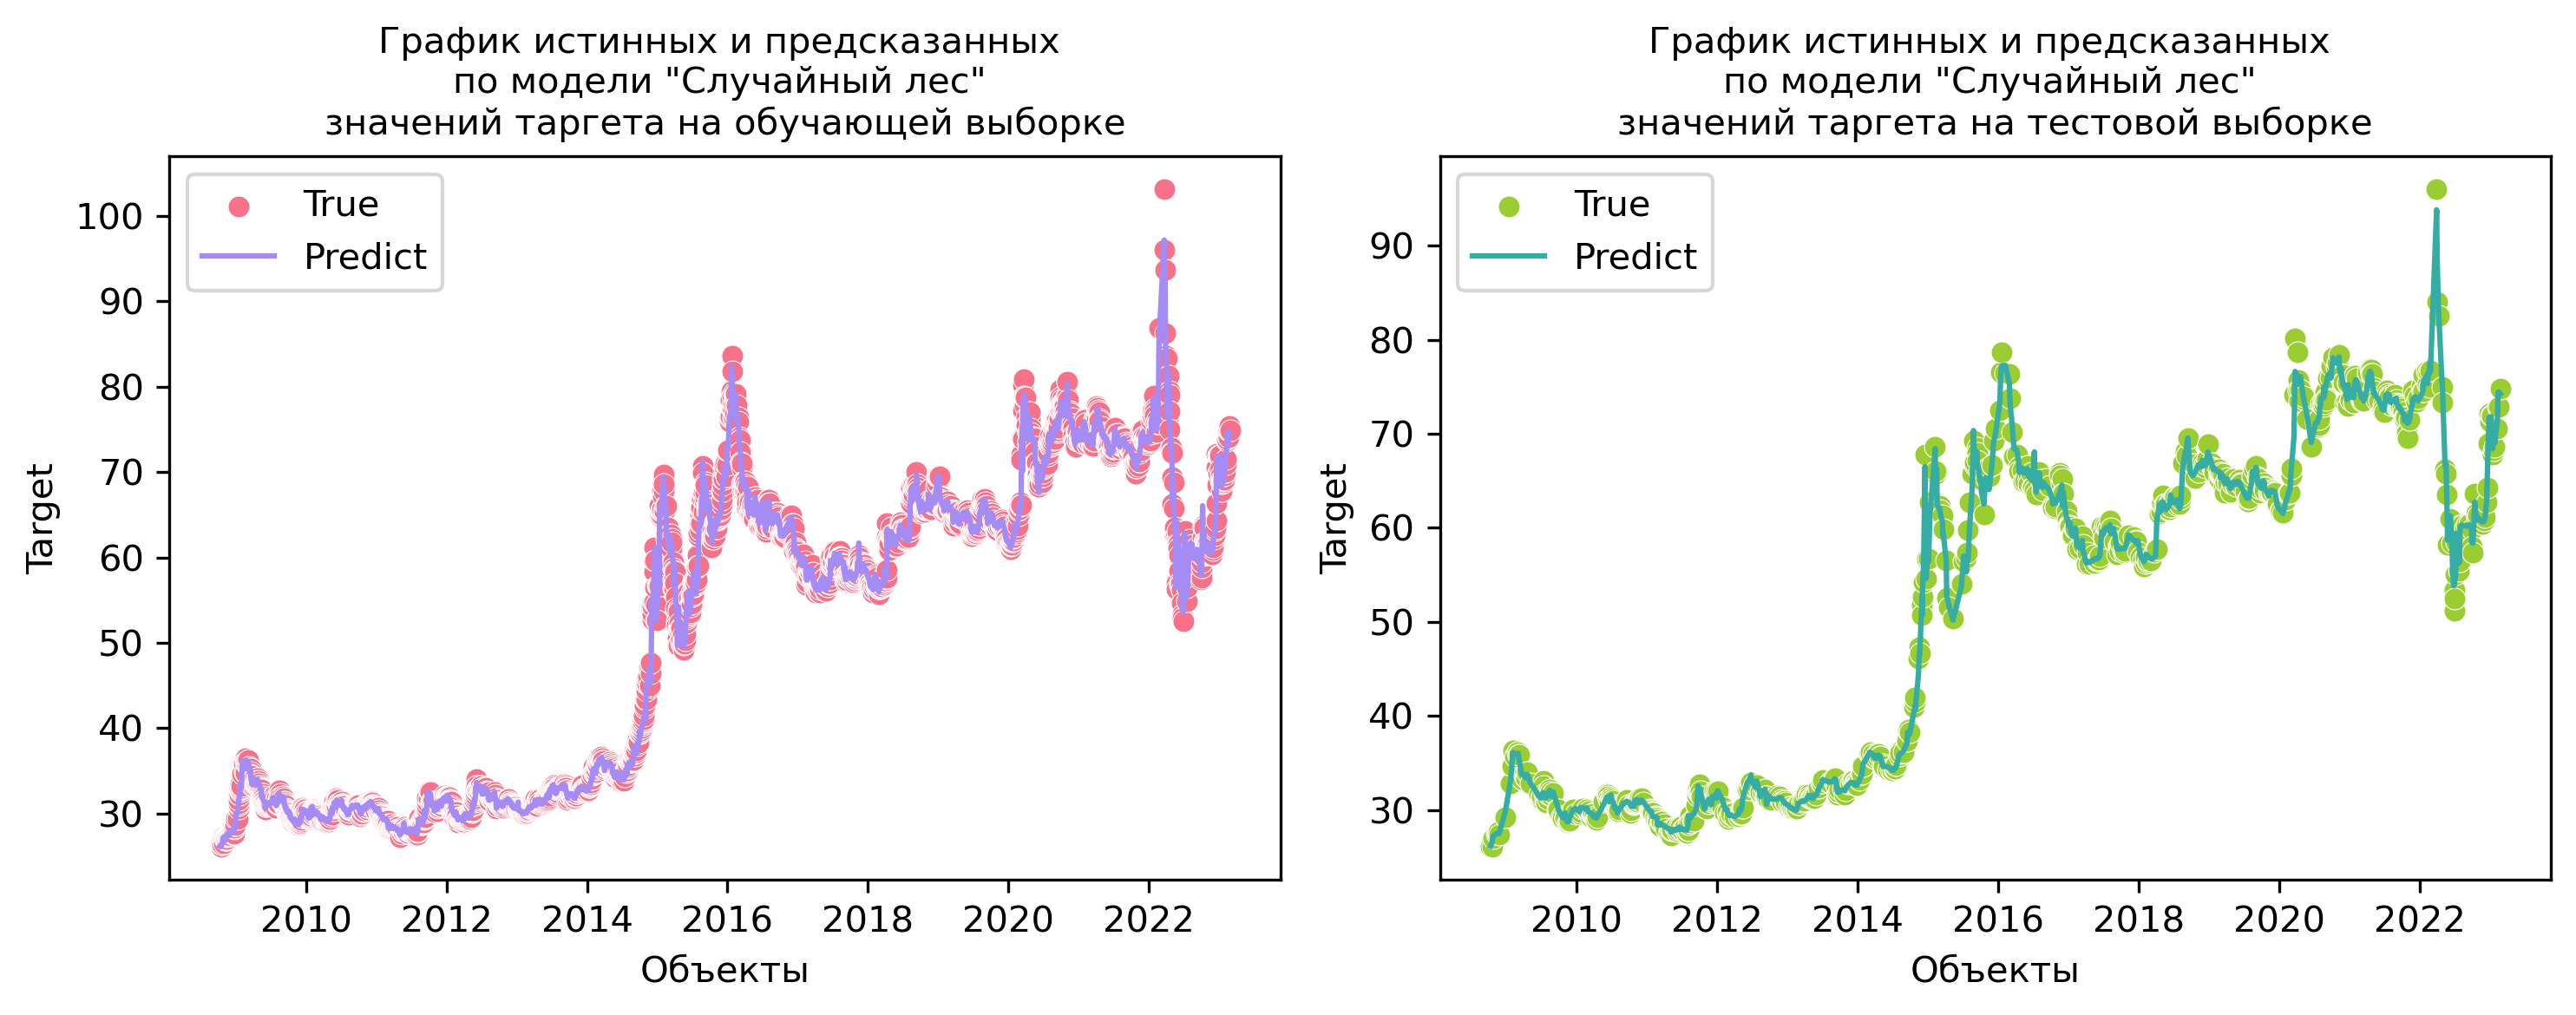

In [35]:
model_name = 'Случайный лес'

best_rf = RandomForestRegressor(n_estimators=best_n_rf, 
                       criterion=best_criterion_rf, 
                       bootstrap=best_bootstrap_rf,
                       max_features=best_maxfeatures_rf,
                       random_state=7)

best_rf.fit(X_train_norm, y_train)
rf_metrics = get_quality(y_train, best_rf.predict(X_train_norm), y_test,
                            best_rf.predict(X_test_norm), model_name)

model_results[model_name] = rf_metrics
dict_printer(rf_metrics)

> Очень хороший результат, но гиперпараметры подбирались очень долго в сравнении с другими моделями

#### Catboost Regressor
Модель градиентного бустинга (т.е. подбора следующей модели исходя из задачи минимизации ошибки кумулятивной модели). Использует симметричные деревья решений для большей устойчивости к переобучению.

In [36]:
from catboost import CatBoostRegressor

Метрики на обучающей выборке
  • MSE: 0.23568308044037856
  • MAE: 0.3656934114166374
  • R^2: 0.9992513093594779
 
Метрики на тестовой выборке
  • MSE: 0.95766279602459
  • MAE: 0.5290949351973334
  • R^2: 0.9970105535768747
 


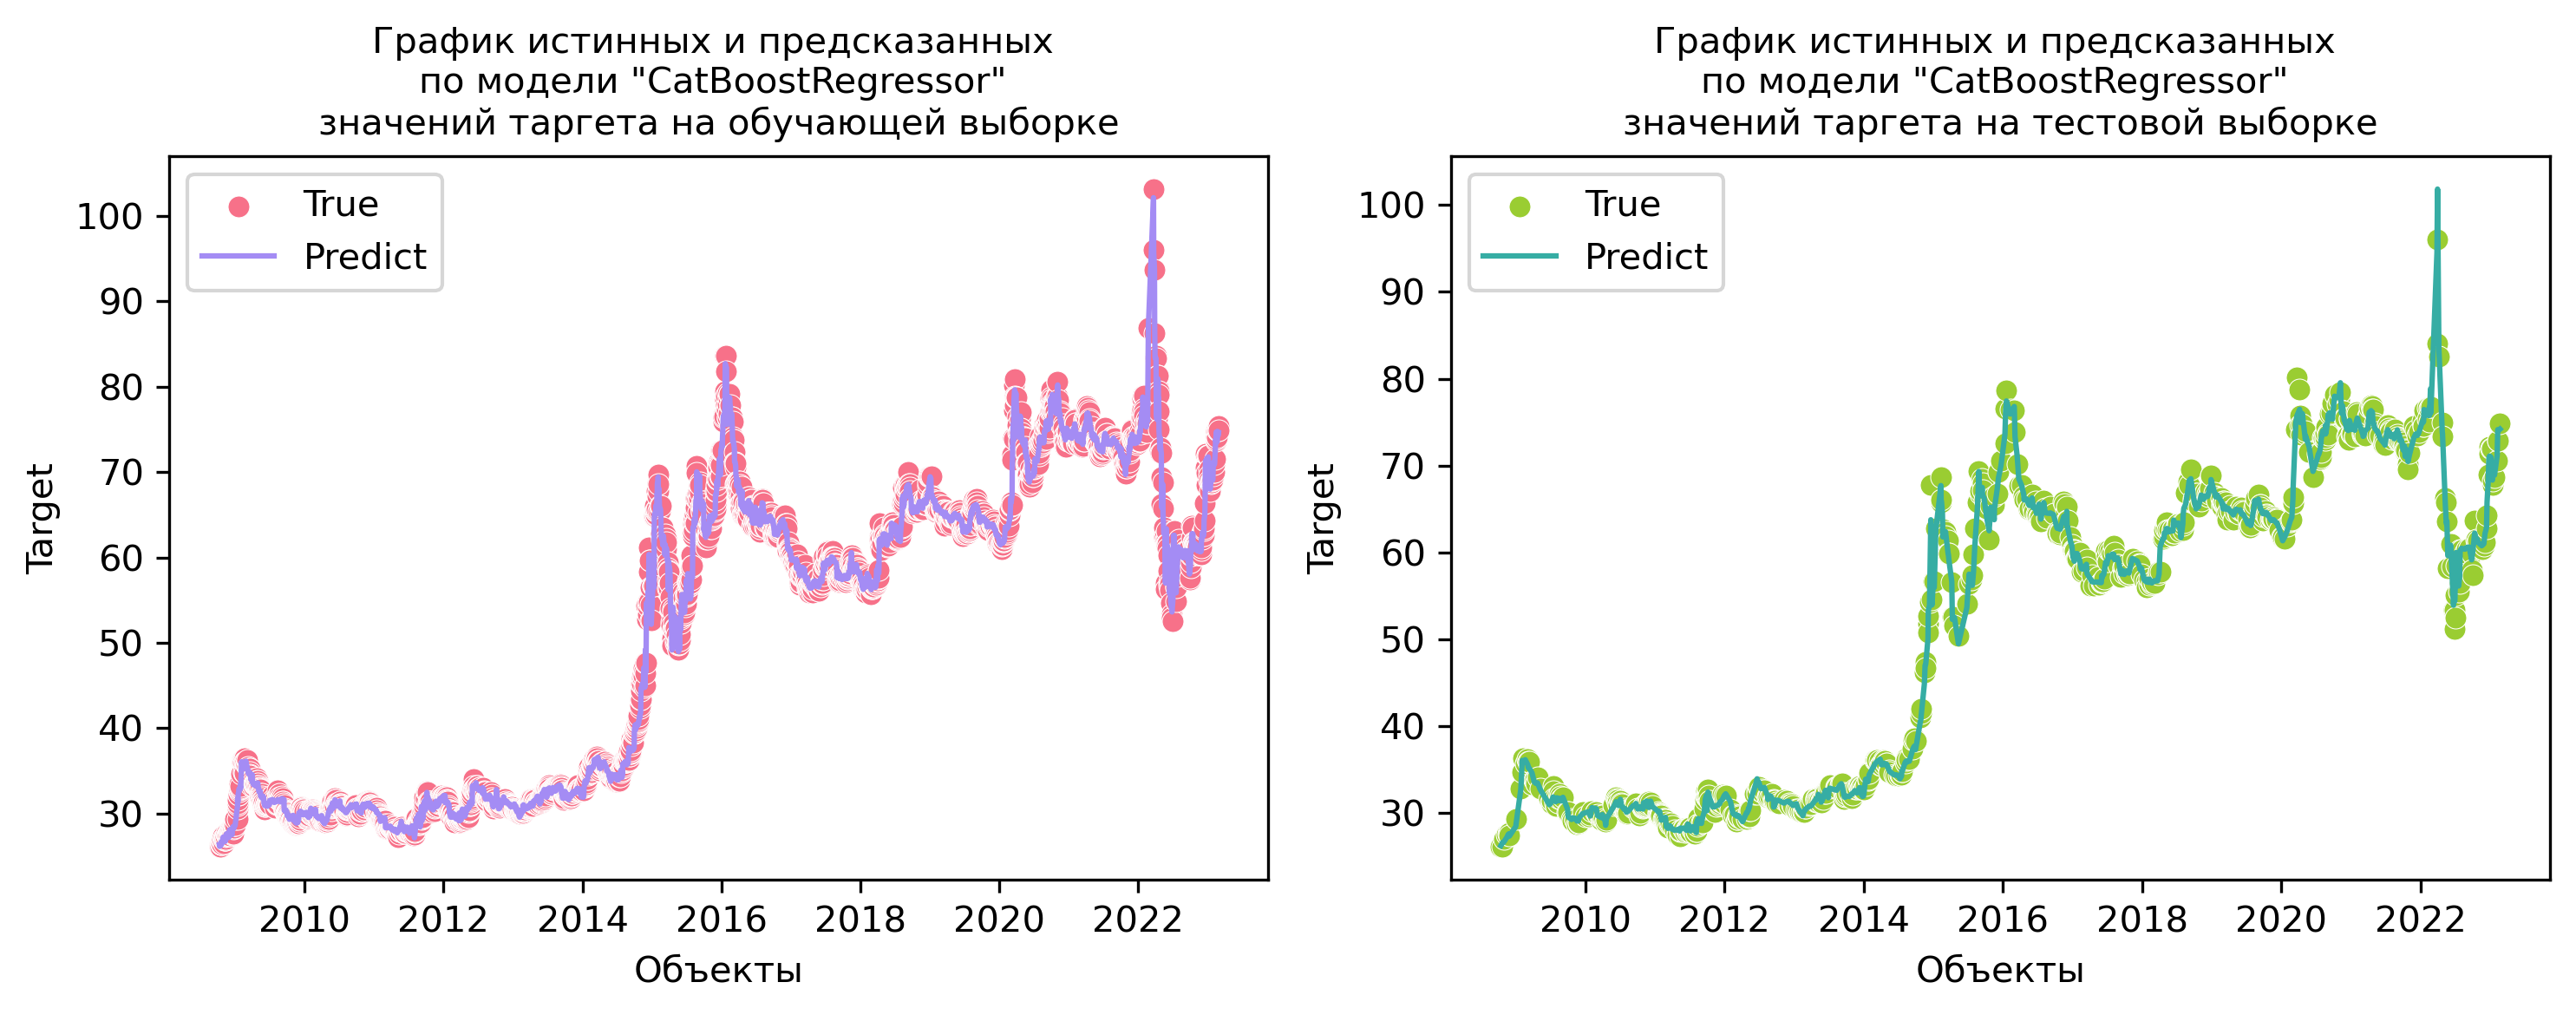

In [37]:
model_name = 'CatBoostRegressor'

cbreg = CatBoostRegressor(random_state=7, logging_level='Silent')

cbreg.fit(X_train_norm, y_train)
cbreg_metrics = get_quality(y_train, cbreg.predict(X_train_norm), y_test,
                            cbreg.predict(X_test_norm), model_name)

model_results[model_name] = cbreg_metrics
dict_printer(cbreg_metrics)

> Очень хороший результат

#### LightGBM Regressor
Тоже модель бустинга. Строит деревья полиственно, а непоуровнево.

In [38]:
from lightgbm import LGBMRegressor

Метрики на обучающей выборке
  • MSE: 0.4573741557356415
  • MAE: 0.4209116590634195
  • R^2: 0.9985470668960365
 
Метрики на тестовой выборке
  • MSE: 0.9616256353003538
  • MAE: 0.5960882326305699
  • R^2: 0.9969981831519741
 


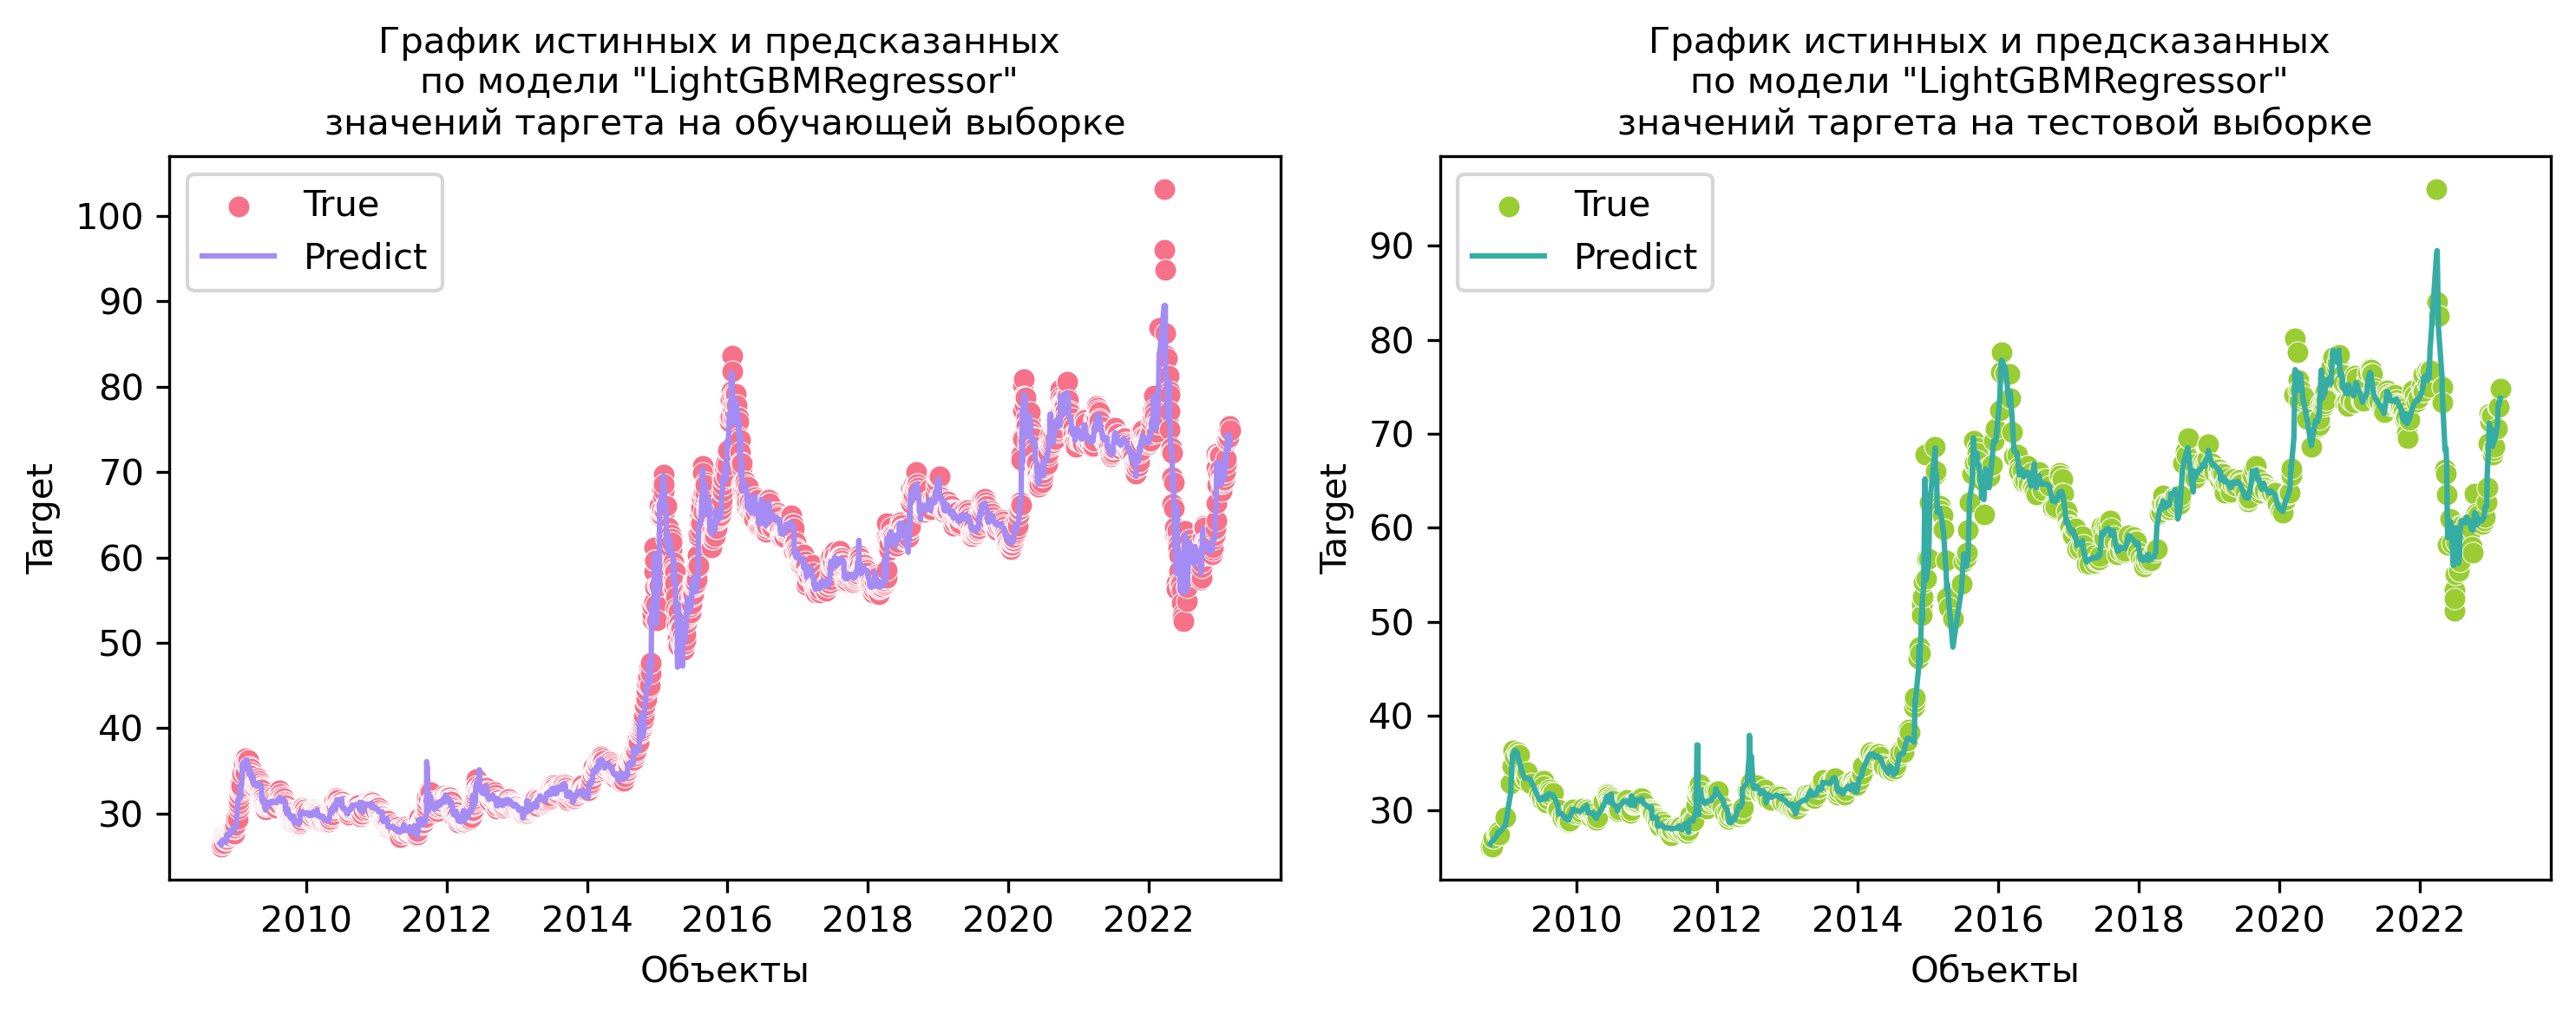

In [39]:
model_name = 'LightGBMRegressor'

lgbm = LGBMRegressor(random_state=7)

lgbm.fit(X_train_norm, y_train)
lgbm_metrics = get_quality(y_train, lgbm.predict(X_train_norm), y_test,
                            lgbm.predict(X_test_norm), model_name)

model_results[model_name] = lgbm_metrics
dict_printer(lgbm_metrics)

> Очень хороший результат

## Итоги
Рассмотрим результаты всех обученных нами моделей.

In [40]:
dict_printer(model_results)

kNN
  Метрики на обучающей выборке
    • MSE: 3.3865665774220832
    • MAE: 1.1624782569444445
    • R^2: 0.9892419485722819
  Метрики на тестовой выборке
    • MSE: 5.144298928357778
    • MAE: 1.533396722222222
    • R^2: 0.983941522950766
 
Линейная регрессия
  Метрики на обучающей выборке
    • MSE: 38.04985696375275
    • MAE: 4.917955856683354
    • R^2: 0.8791276330539552
  Метрики на тестовой выборке
    • MSE: 36.713180787540836
    • MAE: 4.853911160904676
    • R^2: 0.8853958956717726
 
LASSO-регрессия
  Метрики на обучающей выборке
    • MSE: 52.270998626489344
    • MAE: 5.818943061210426
    • R^2: 0.8339515616934903
  Метрики на тестовой выборке
    • MSE: 50.39126174234722
    • MAE: 5.790578931309382
    • R^2: 0.8426983090522404
 
Ridge-регрессия
  Метрики на обучающей выборке
    • MSE: 39.21747445252734
    • MAE: 5.091057269855979
    • R^2: 0.8754184814087802
  Метрики на тестовой выборке
    • MSE: 37.4451030542552
    • MAE: 5.010267252453557
    • R^2: 0.883111

Есть несколько явных лидеров: случайный лес, CatBoost и LightGBM.

Если оценивать модели исключительно по их качеству, то несложно заметить, что выигрывает случайный лес: он имеет наименьшие MSE, MAE и наибольший $R^2$ из трёх моделей. 

Однако другой важный параметр - удобство в использовании. Стоит отметить, что подбор гиперпараметров для случайного леса занял немало времени при том, что:
1) Наш датасет имеет достаточно скромные размеры по сравнению с темии, которые используются в реальной жизни,

2) Подбирались не все гиперпараметры (так как подбор всех параметров слишком "дорогой" по времени)

При этом разница в качестве сравнении с рассмотренными моделями бустинга минимальна, из чего напрашивается вывод, что эти крупицы качества не стоят затрачиваемых ресурсов. Так как из двух бустингов лучше себя показал CatBoost, мы считаем его лучшей моделью на наших данных.